In [1]:
from itertools import permutations
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scikit_posthocs as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [2]:
products_df = pd.DataFrame()

if not os.path.isfile("products_df5.ftr"):
    # exit() crashes kernel
    sys.exit(
        'The file "products_df5.ftr" was not found! Please run "Hermel_Gabriel_1_notebook_nettoyage_092022.ipynb" in the same directory first.'
    )
else:
    products_df = pd.read_feather("products_df5.ftr")


In [3]:
products_df_sel_categ = products_df.loc[products_df["select_category"].notnull()]
products_df_sel_categ.reset_index(drop=True, inplace=True)
products_df_sel_categ = products_df_sel_categ.dropna(
    axis=1, thresh=products_df_sel_categ.shape[0] * 0.2
)
products_df_sel_categ.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298110 entries, 0 to 298109
Data columns (total 68 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   code                      298110 non-null  object 
 1   product_name              296922 non-null  object 
 2   brands                    216994 non-null  object 
 3   primary_category          298110 non-null  object 
 4   secondary_category        298110 non-null  object 
 5   tertiary_category         298110 non-null  object 
 6   select_category           298110 non-null  object 
 7   energy-kcal_100g          298110 non-null  float64
 8   proteins_100g             298110 non-null  float64
 9   carbohydrates_100g        298110 non-null  float64
 10  sugars_100g               295593 non-null  float64
 11  fat_100g                  298110 non-null  float64
 12  saturated-fat_100g        290445 non-null  float64
 13  monounsaturated-fat_100g  173882 non-null  f

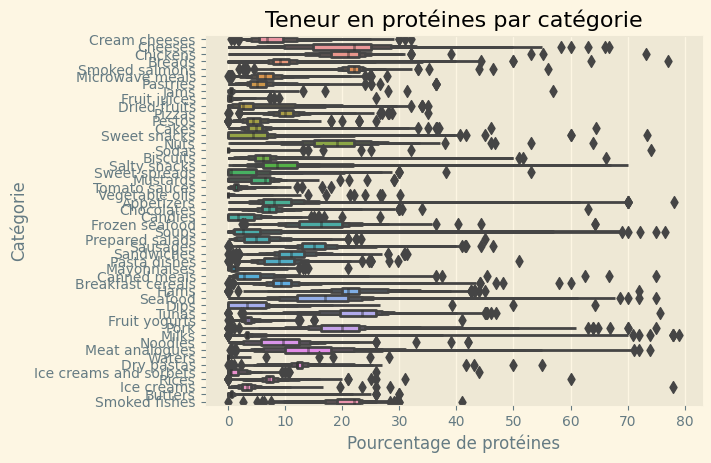

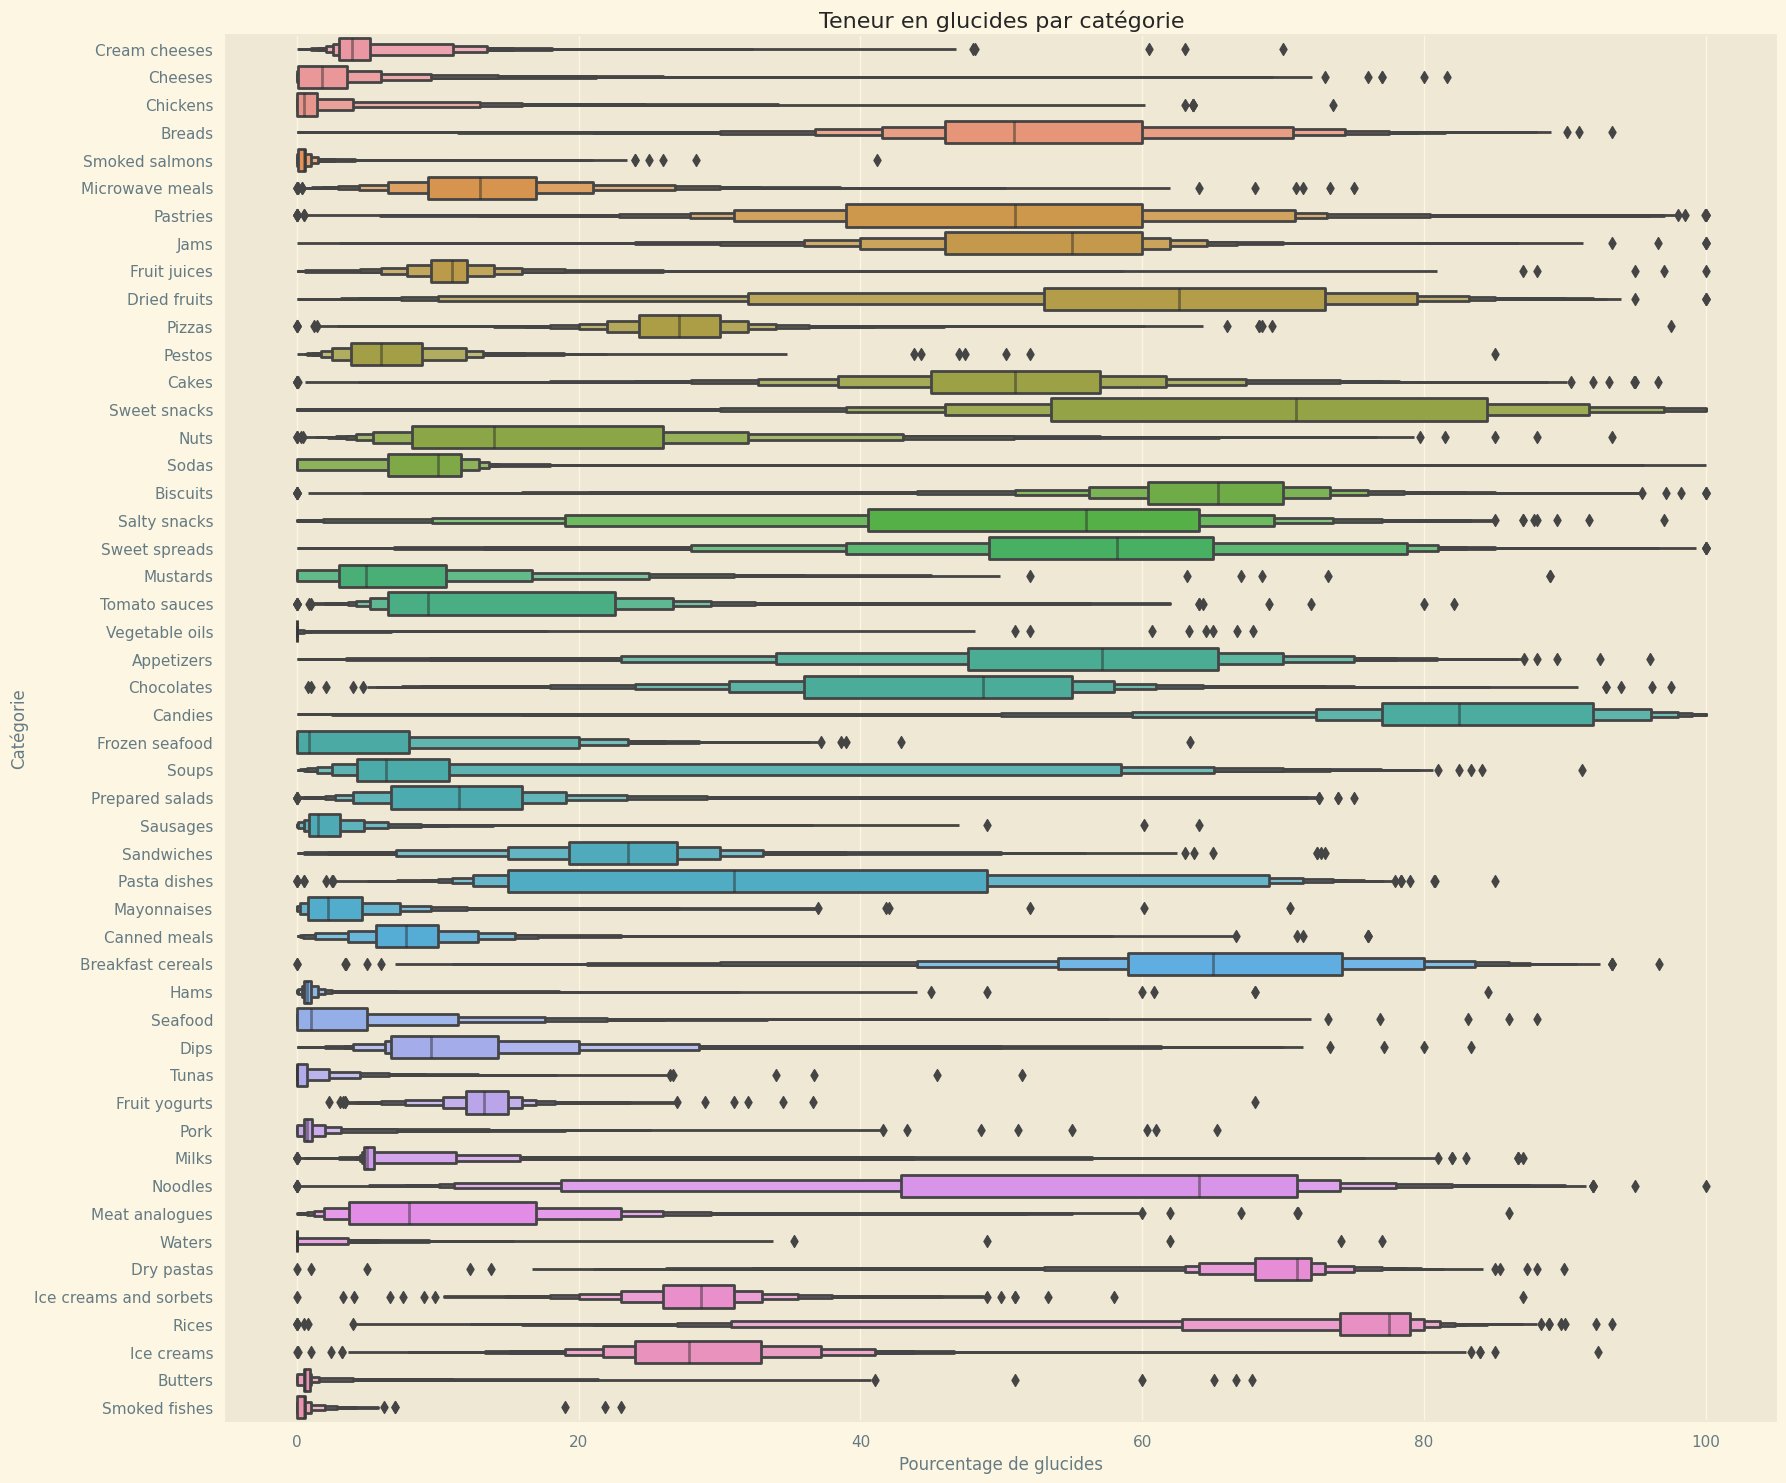

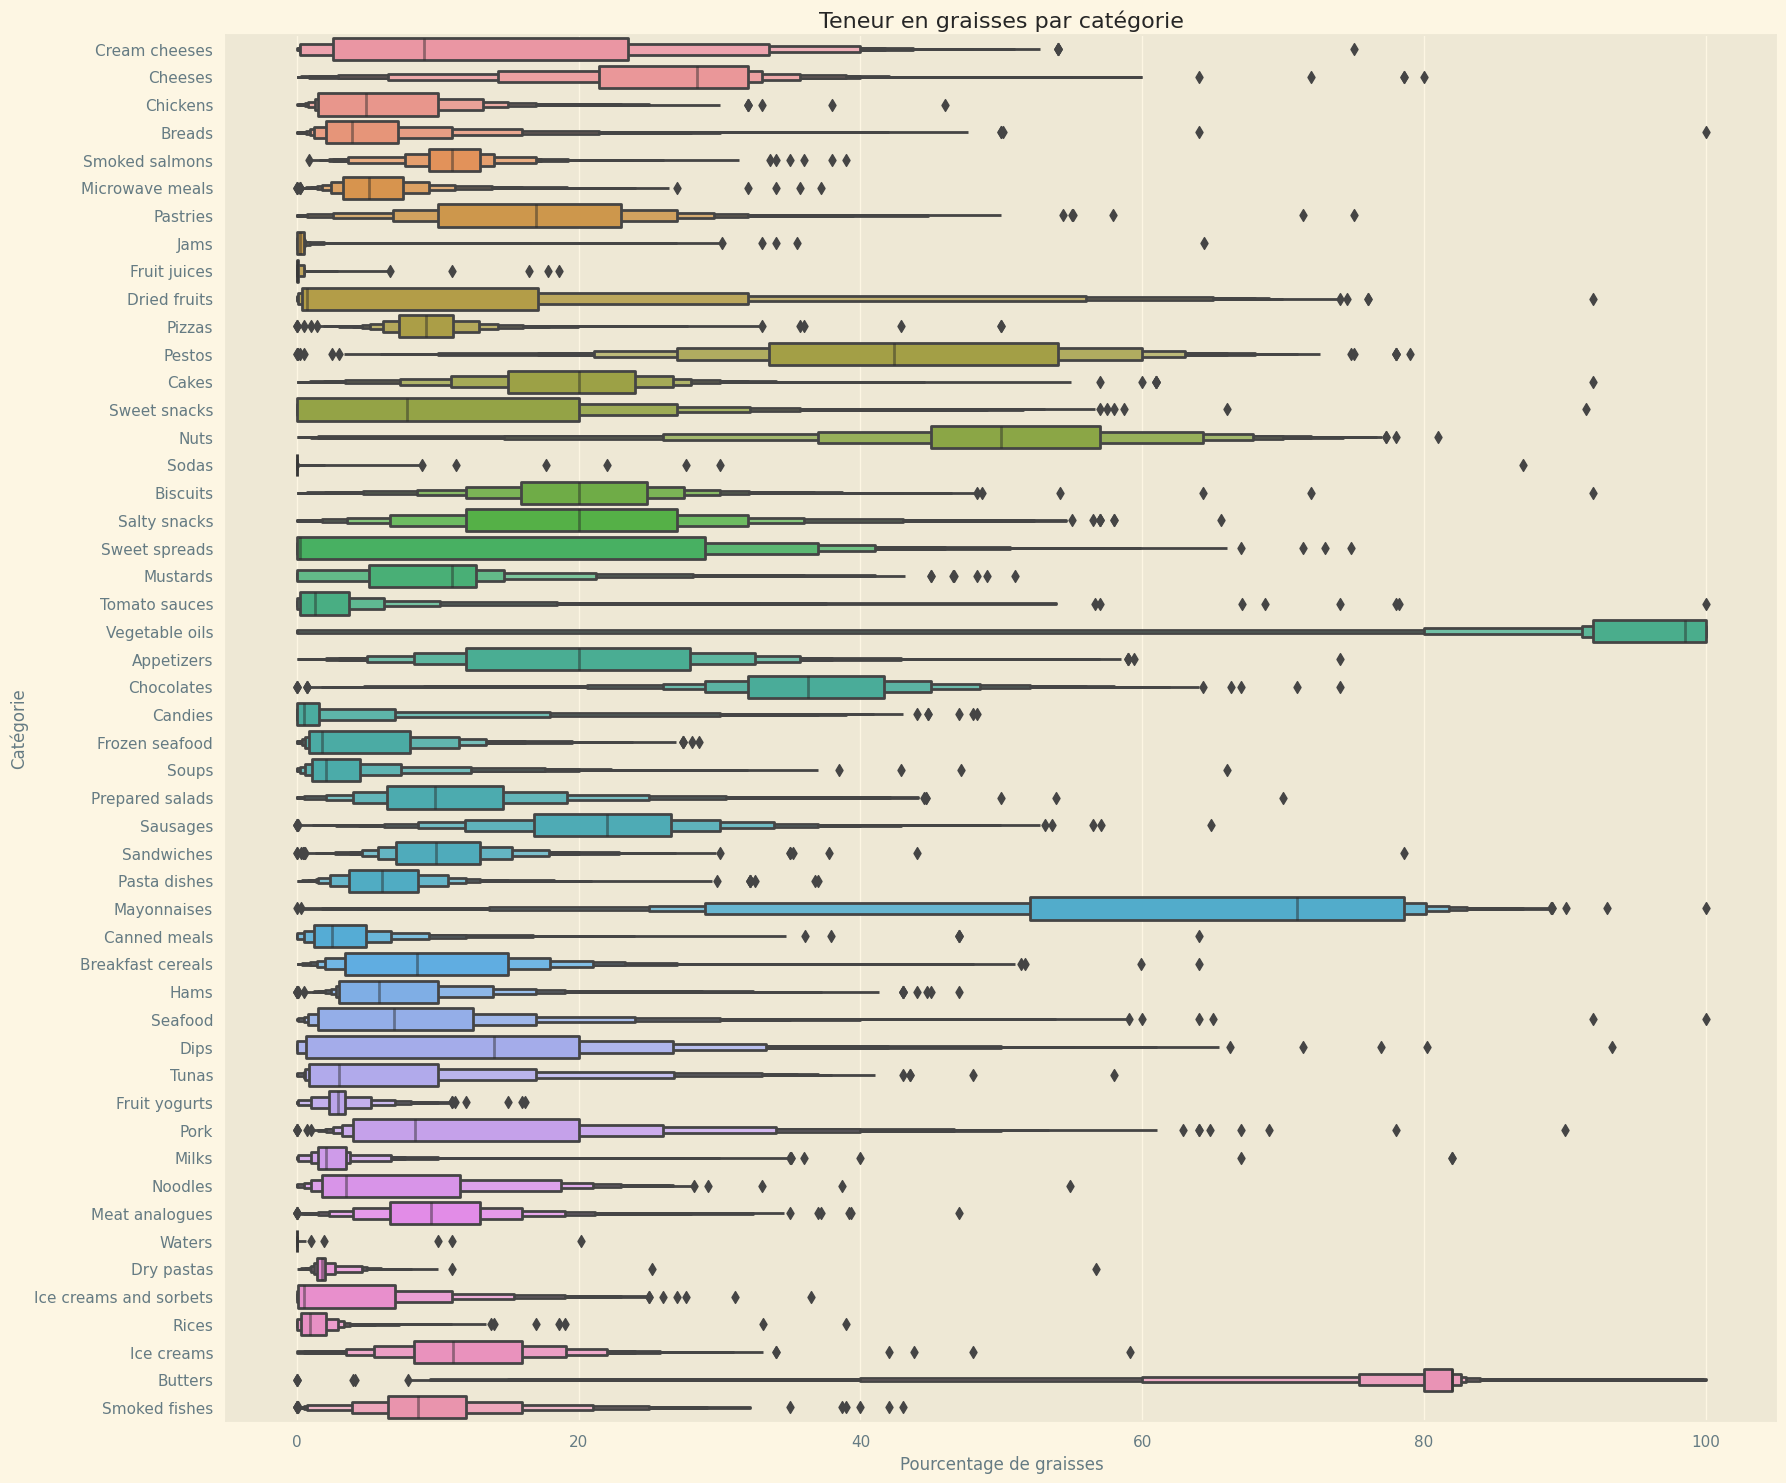

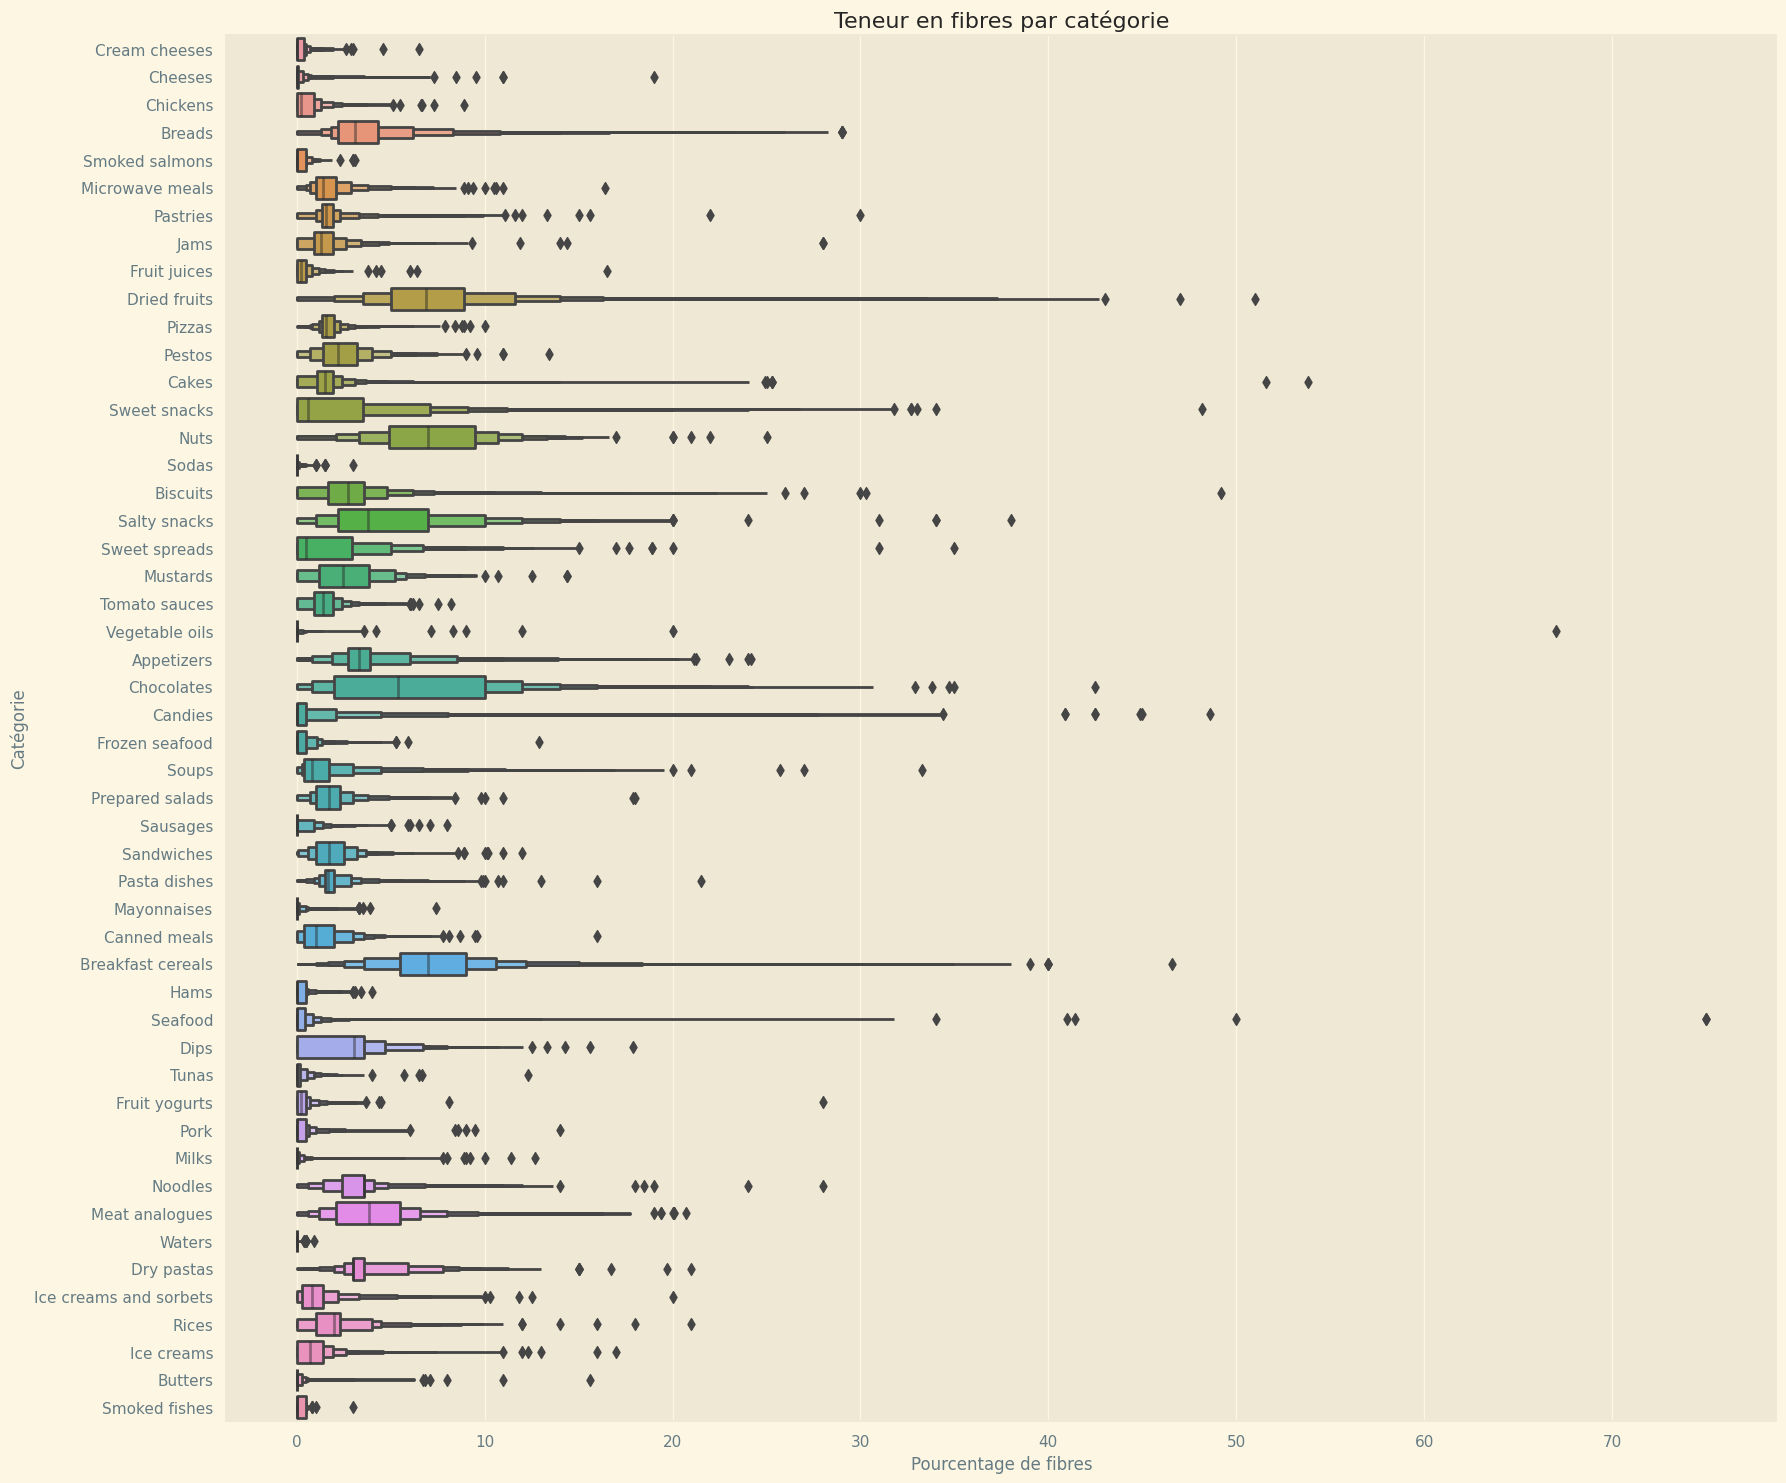

In [4]:
macro_cols_names = [
    ["proteins_100g", "protéines"],
    ["carbohydrates_100g", "glucides"],
    ["fat_100g", "graisses"],
    ["fiber_100g", "fibres"],
]

for macro_col_name in macro_cols_names:
    plt.style.use("Solarize_Light2")
    sns.boxenplot(
        y=products_df_sel_categ["select_category"],
        x=products_df_sel_categ[macro_col_name[0]],
        # flierprops=dict(markerfacecolor="0.75", markersize=3, linestyle="none"),
    ).set(
        xlabel=f"Pourcentage de {macro_col_name[1]}",
        ylabel="Catégorie",
        title=f"Teneur en {macro_col_name[1]} par catégorie",
    )
    sns.set(rc={"figure.figsize": (20, 18)})
    plt.show()


In [5]:
len(products_df_sel_categ["select_category"].unique())

50

In [6]:
for macro_col_name in macro_cols_names:
    anova_result = sm.stats.anova_lm(
        ols(f"{macro_col_name[0]} ~ select_category", data=products_df_sel_categ).fit(),
        typ=2,
    )
    print(
        f"{macro_col_name[1]} : variable dépendante\ncatégorie : variable indépendante\n{anova_result}\n"
    )


protéines : variable dépendante
catégorie : variable indépendante
                       sum_sq        df             F  PR(>F)
select_category  1.388086e+07      49.0  15943.224132     0.0
Residual         5.295999e+06  298060.0           NaN     NaN

glucides : variable dépendante
catégorie : variable indépendante
                       sum_sq        df             F  PR(>F)
select_category  2.135462e+08      49.0  32070.084668     0.0
Residual         4.050413e+07  298060.0           NaN     NaN

graisses : variable dépendante
catégorie : variable indépendante
                       sum_sq        df             F  PR(>F)
select_category  9.342034e+07      49.0  23627.622457     0.0
Residual         2.405077e+07  298060.0           NaN     NaN

fibres : variable dépendante
catégorie : variable indépendante
                       sum_sq        df            F  PR(>F)
select_category  7.357180e+05      49.0  2892.486652     0.0
Residual         1.137111e+06  219058.0          NaN     N

In [7]:
categs_f_p = {}

for macro_col_name in macro_cols_names:
    categ_macro_vals = [
        products_df_sel_categ.loc[products_df_sel_categ["select_category"] == categ][
            macro_col_name[0]
        ]
        .dropna()
        .to_list()
        for categ in products_df_sel_categ["select_category"].unique()
    ]
    f_stat, p_val = stats.f_oneway(*categ_macro_vals)
    categs_f_p[macro_col_name[1]] = [f_stat, p_val]

for macro_col_name in macro_cols_names:
    print(
        f"{macro_col_name[1]} : variable dépendante\ncatégorie : variable indépendante\n"
        + f"statistique F : {categs_f_p[macro_col_name[1]][0]}\n"
        + f"valeur-p : {categs_f_p[macro_col_name[1]][1]}\n"
    )


protéines : variable dépendante
catégorie : variable indépendante
statistique F : 15943.224131798239
valeur-p : 0.0

glucides : variable dépendante
catégorie : variable indépendante
statistique F : 32070.084668292457
valeur-p : 0.0

graisses : variable dépendante
catégorie : variable indépendante
statistique F : 23627.62245702785
valeur-p : 0.0

fibres : variable dépendante
catégorie : variable indépendante
statistique F : 2892.4866517460828
valeur-p : 0.0



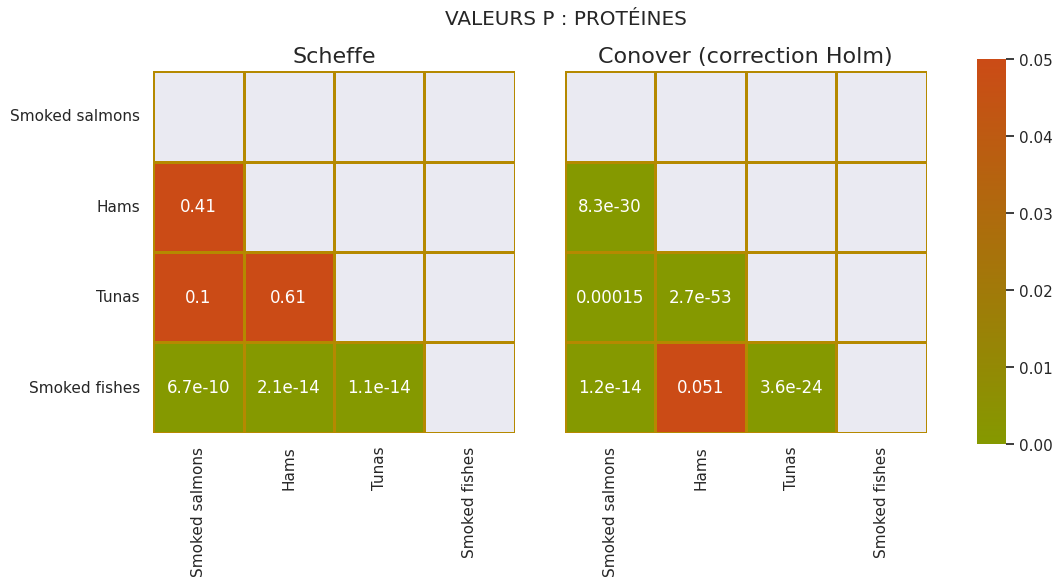

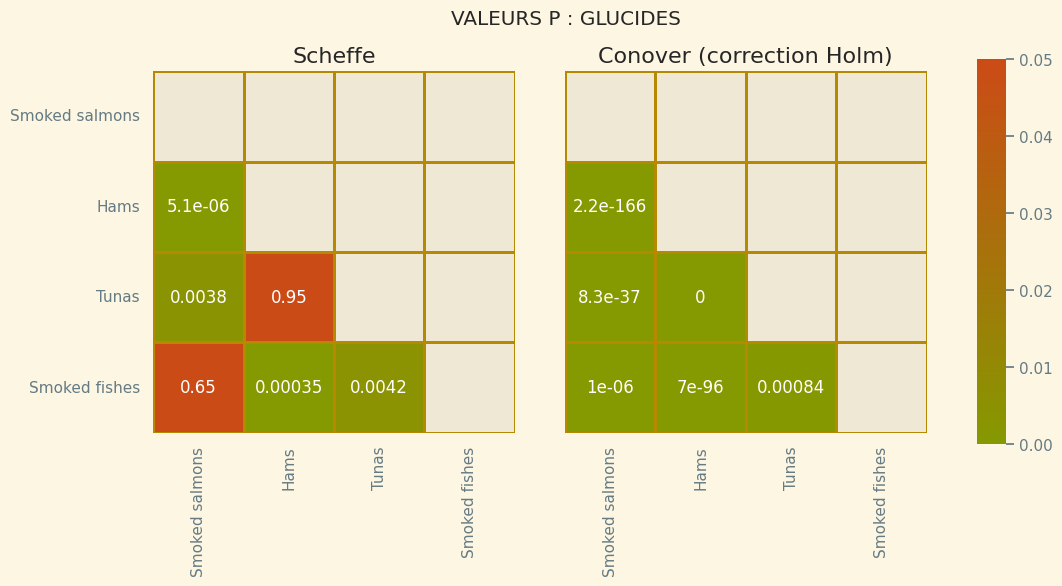

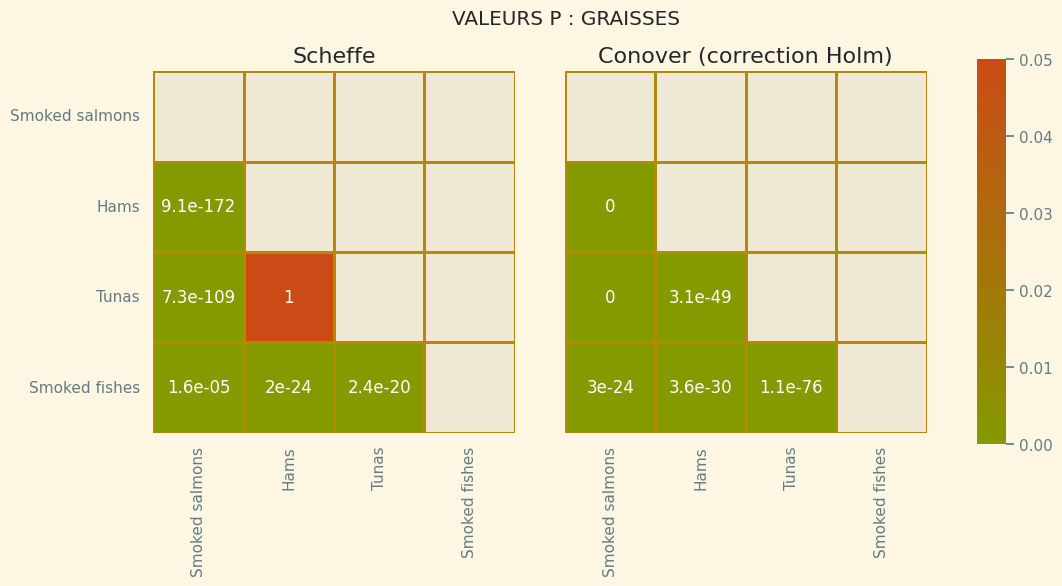

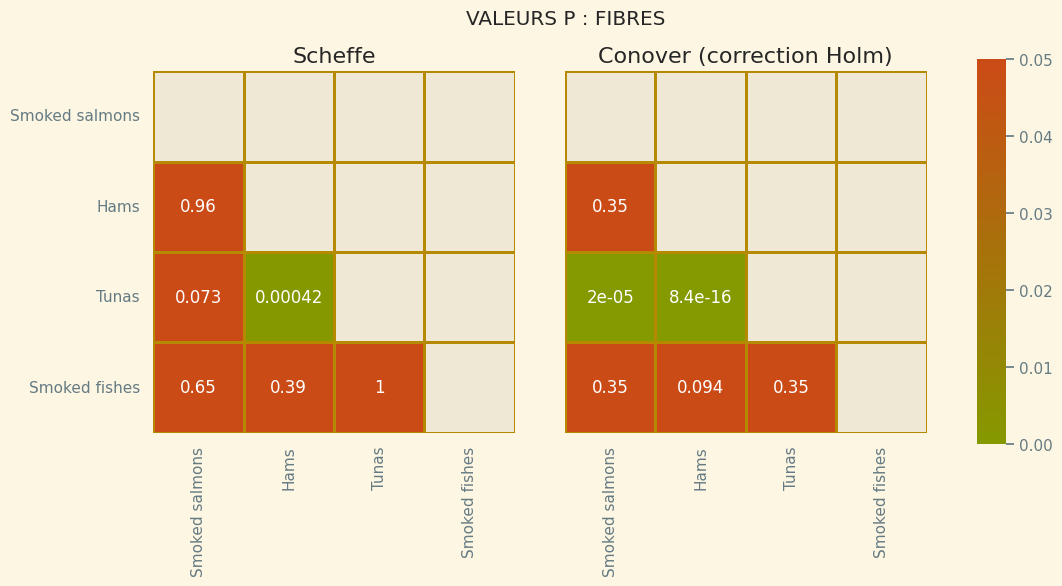

In [8]:
alpha = 0.05
macro_cat_pair_p_vals = {}

for macro_col_name in macro_cols_names:
    scheffe_df = sp.posthoc_scheffe(
        products_df_sel_categ, val_col=macro_col_name[0], group_col="select_category"
    )
    cat_pair_p_val = {}

    for index, row in scheffe_df.iterrows():
        for item in row.iteritems():
            if item[0] != index and item[1] > alpha:
                categs = [item[0], index]
                categs.sort()
                categs_str = ", ".join(categs)
                cat_pair_p_val[categs_str] = item[1]

    macro_cat_pair_p_vals[macro_col_name[0]] = cat_pair_p_val

holding_set = set()
first_loop = True

for macro in macro_cat_pair_p_vals:
    if first_loop:
        holding_set = set(macro_cat_pair_p_vals[macro].keys())
        first_loop = False
    else:
        holding_set = holding_set.intersection(macro_cat_pair_p_vals[macro].keys())

products_df_close_macro_categs = products_df_sel_categ.loc[
    products_df_sel_categ["select_category"].isin(", ".join(holding_set).split(", "))
]

for macro_col_name in macro_cols_names:
    ph_scheffe_df = sp.posthoc_scheffe(
        products_df_close_macro_categs,
        val_col=macro_col_name[0],
        group_col="select_category",
    )
    ph_scheffe_cols = ph_scheffe_df.columns.tolist()
    ph_scheffe_rows = ph_scheffe_df.index.tolist()
    ph_conov_df = sp.posthoc_conover(
        products_df_close_macro_categs[
            products_df_close_macro_categs[macro_col_name[0]].notna()
        ],
        val_col=macro_col_name[0],
        group_col="select_category",
        p_adjust="holm",
    )
    ph_conov_df = ph_conov_df[ph_scheffe_cols]
    ph_conov_df = ph_conov_df.reindex(ph_scheffe_rows)
    posthocs = [["Scheffe", ph_scheffe_df], ["Conover (correction Holm)", ph_conov_df]]
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(11, 5), gridspec_kw={"width_ratios": [1, 1, 0.08]}
    )

    plt.style.use("Solarize_Light2")

    theme_clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    cmap = lsc.from_list("GrOrRd", [theme_clrs[2], theme_clrs[4]])
    first_loop = True

    for posthoc in posthocs:
        mask = np.zeros_like(posthoc[1])

        mask[np.triu_indices_from(mask)] = True
        if first_loop:
            g1 = sns.heatmap(
                posthoc[1],
                vmin=0.0,
                vmax=alpha,
                cmap=cmap,
                annot=True,
                linewidths=1,
                linecolor=theme_clrs[3],
                cbar=False,
                square=True,
                mask=mask,
                ax=ax1,
            )
            ax1.set_title(posthoc[0])
            first_loop = False
        else:
            g2 = sns.heatmap(
                posthoc[1],
                vmin=0.0,
                vmax=alpha,
                cmap=cmap,
                annot=True,
                linewidths=1,
                linecolor=theme_clrs[3],
                cbar_ax=ax3,
                square=True,
                mask=mask,
                ax=ax2,
            )
            ax2.set_title(posthoc[0])
        plt.suptitle(f"VALEURS P : {macro_col_name[1].upper()}")

    for ax in [ax1, ax2]:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax2.set_yticklabels([])
    plt.show()


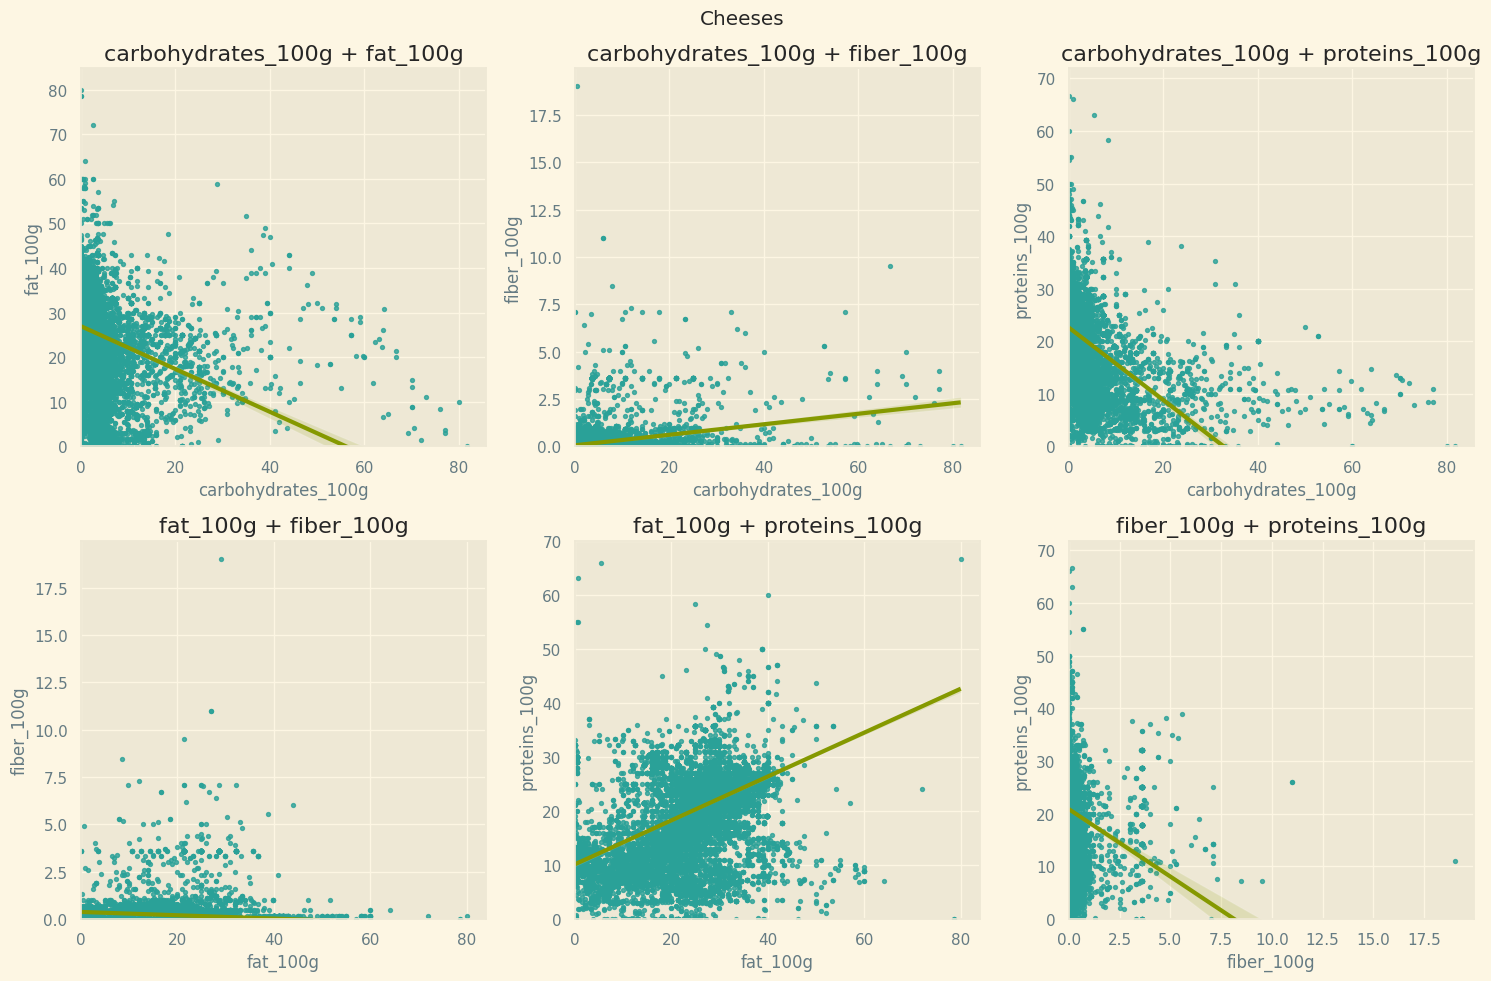

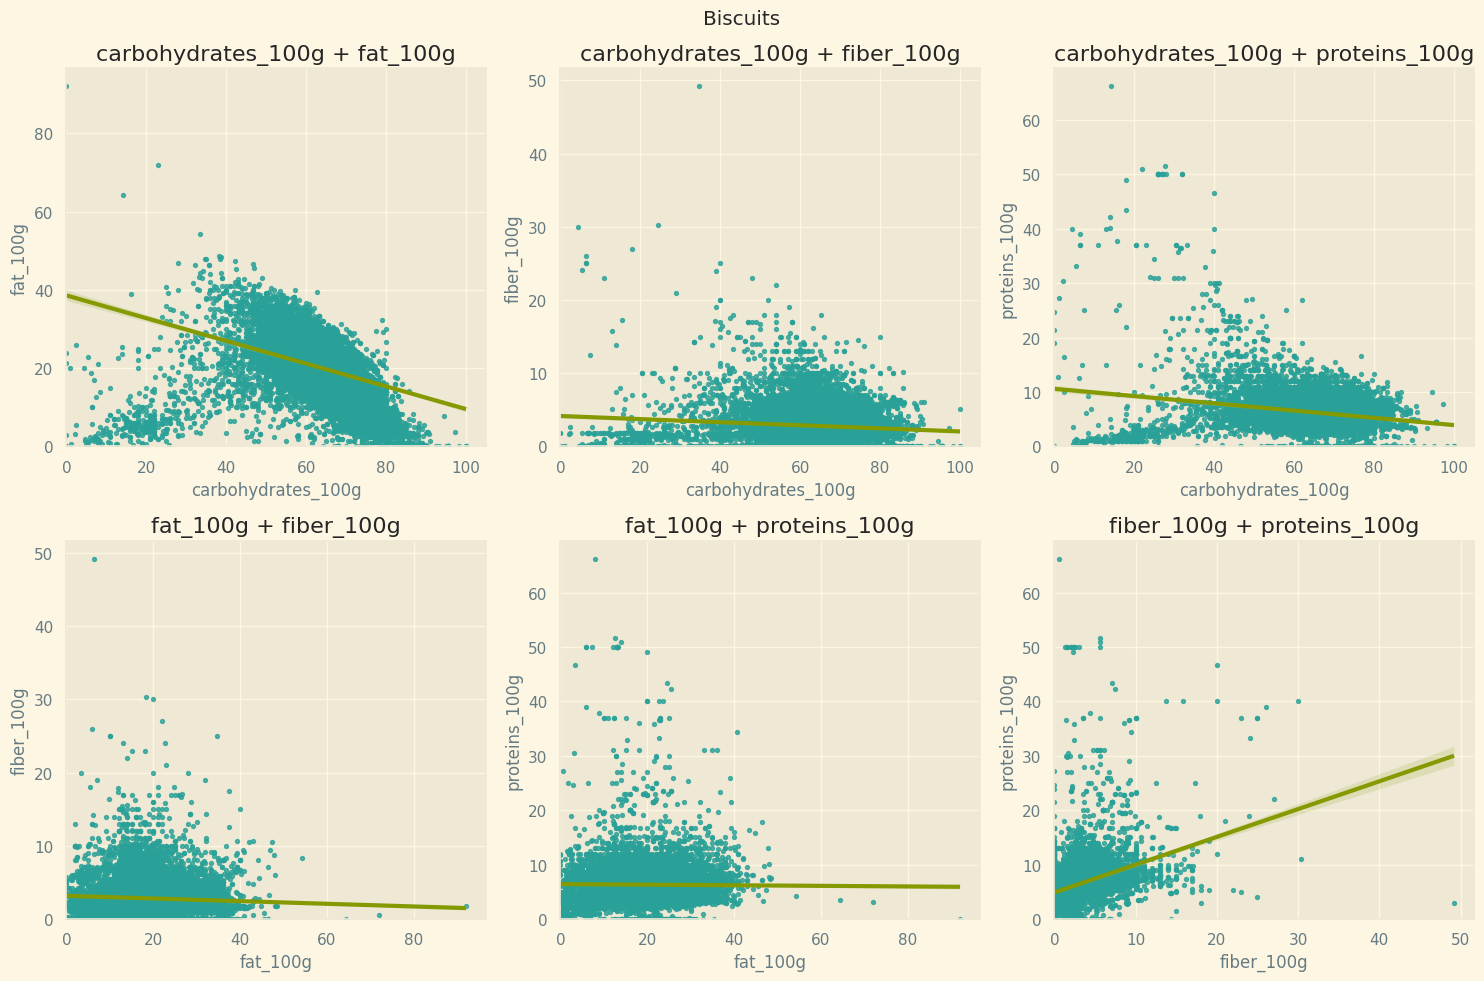

In [9]:
num_categs_bivar = 2
top_categs = list(
    products_df_sel_categ["select_category"].value_counts().to_dict().keys()
)[:num_categs_bivar]
macro_perm_set = set()

for i in permutations([macro_col_name[0] for macro_col_name in macro_cols_names], 2):
    macro_perm_set.add(tuple(sorted(i)))

macro_perm_set = sorted(macro_perm_set)






# for top_categ in top_categs:
#     plt.style.use("Solarize_Light2")
#     fig, (ax1, ax2) = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
#     sp_locs = [i for i in ax1] + [i for i in ax2]
#     loop_num = 0
#     categ_df = products_df_sel_categ.loc[
#         products_df_sel_categ["select_category"] == top_categ
#     ]

#     for macro_perm in macro_perm_set:
#         rp = sns.regplot(
#             data=categ_df,
#             x=macro_perm[0],
#             y=macro_perm[1],
#             ax=sp_locs[loop_num],
#             line_kws={"color": theme_clrs[2]},
#             scatter_kws={"color": theme_clrs[1], "s": 8},
#         )
#         rp.set(xlim=(0, None))
#         rp.set(ylim=(0, None))

#         test_df = products_df_sel_categ.loc[
#             products_df_sel_categ["select_category"] == "Cheeses"
#         ]
#         test_df = test_df.loc[
#             test_df["proteins_100g"].notnull() & test_df["fiber_100g"].notnull()
#         ]
#         fiber_list = test_df["fiber_100g"].to_list()

#         sp_locs[loop_num].set_title(f"{macro_perm[0]} + {macro_perm[1]}")
#         loop_num += 1

#     plt.suptitle(f"{top_categ}")
#     plt.tight_layout()
#     plt.show()


In [10]:
test_df = products_df_sel_categ.loc[products_df_sel_categ["select_category"] == "Cheeses"]
test_df = test_df.loc[test_df["proteins_100g"].notnull() & test_df["fiber_100g"].notnull()]
fiber_list = test_df["fiber_100g"].to_list()